In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode

In [1]:
from pymarkowitz import *

In [3]:
init_notebook_mode(connected=True)

In [4]:
%load_ext autoreload
%autoreload 2

## Data Preparation
- Selecting 15 Assets with 1000 Observations
- Calculate Annualized Mean Return and Covariance Matrix and Beta

In [5]:
sp500 = pd.read_csv("datasets/sp500_1990_2000.csv", index_col='DATE').drop(["Unnamed: 0"], axis=1)
sp500.head()

AAPL   ABMD    ABT   ADBE     ADM    ADSK     AEP     AFL  \
DATE                                                                     
01/02/1990  1.330  5.875  3.874  1.282  8.4918  5.0313  33.125  1.1750   
01/03/1990  1.339  5.813  3.888  1.345  8.5382  5.1563  33.000  1.1500   
01/04/1990  1.344  5.625  3.881  1.408  8.4918  5.0313  32.500  1.1250   
01/05/1990  1.348  5.750  3.839  1.440  8.0741  5.0313  31.750  1.1250   
01/08/1990  1.357  5.750  3.839  1.456  8.2134  4.9844  31.625  1.1333   

                 AIG     AJG  ...      WEC     WFC     WHR     WMB     WMT  \
DATE                          ...                                            
01/02/1990  148.9705  6.1875  ...  10.6667  2.8281  32.250  4.9662  5.9219   
01/03/1990  148.7940  6.1563  ...  10.4583  2.7031  32.375  5.0755  5.8906   
01/04/1990  146.6759  6.1563  ...  10.4167  2.6719  32.750  4.9194  5.8594   
01/05/1990  142.2633  6.1563  ...  10.2500  2.5938  32.000  4.9350  5.7969   
01/08/1990  141.3807  6.1563  ...  10.1667  2.6719  32.250  4.9974  5.8750   

                 WY      XOM    XRAY      XRX    ZION  
DATE                                                   
01/02/1990  11.6129  12.5000  1.0417  25.4128  3.5000  
01/03/1990  11.3571  12.3750  1.0417  25.5775  3.5625  
01/04/1990  11.2548  12.2500  1.0000  25.6324  3.5625  
01/05/1990  11.2036  12.2188  1.0625  25.6873  3.5625  
01/08/1990  11.2036  12.3750  1.0208  25.5226  3.5625  

[5 rows x 203 columns]

In [6]:
selected = sp500.iloc[:1000, np.random.choice(np.arange(0, sp500.shape[1]), 15, replace=False)]
selected.head()

HUM     LHX        K     KSU    INTC      XOM     TGT    FISV  \
DATE                                                                           
01/02/1990  10.420  7.0925  17.1875  0.2377  1.1250  12.5000  5.4063  0.4719   
01/03/1990  10.391  6.8899  16.9063  0.2377  1.0938  12.3750  5.4583  0.4829   
01/04/1990  10.302  6.8392  16.8750  0.2384  1.1172  12.2500  5.4792  0.4938   
01/05/1990  10.272  6.8899  16.7813  0.2371  1.1094  12.2188  5.4792  0.4993   
01/08/1990  10.183  6.8899  16.7188  0.2417  1.1250  12.3750  5.5313  0.4993   

                CVX    EXPD      HP      GPC       AIG     AON     GPS  
DATE                                                                    
01/02/1990  17.3125  0.8203  6.3150  18.8889  148.9705  12.556  1.9491  
01/03/1990  17.0000  0.8516  6.0633  18.6667  148.7940  12.519  1.9676  
01/04/1990  16.7813  0.8516  5.9031  18.6111  146.6759  12.333  1.9815  
01/05/1990  16.5313  0.8281  5.9489  18.6667  142.2633  12.074  1.9722  
01/08/1990  16.6563  0.8516  6.0862  18.7222  141.3807  11.852  1.9444

In [7]:
px.line(pd.melt(selected.reset_index(), id_vars='DATE'), x='DATE', y='value', color='variable', title='Price from 1990 - 1993')

In [8]:
px.line(pd.melt((selected/selected.iloc[0]).reset_index(), id_vars='DATE'), x='DATE', y='value', color='variable', title='Cumulative from 1990 - 1993')

In [9]:
ret_generator = ReturnGenerator(selected)

In [10]:
mu_return = ret_generator.calc_mean_return(method='geometric')

In [11]:
daily_return = ret_generator.calc_return(method='daily')

In [12]:
mom_generator = MomentGenerator(daily_return)

In [13]:
cov_matrix = mom_generator.calc_cov_mat(method='exp', decay=0.94, span=30)

In [14]:
beta_vec = mom_generator.calc_beta(beta_vec=sp500.iloc[:1000].pct_change().dropna(how='any').sum(axis=1)/sp500.shape[1], method='exp', decay=0.94, span=30)

## Performing Simulations
- Initialization
- Selecting X/Y Variable
- Adding Portfolio Composition Constraints to Weight Generation

### Initialization
- Setting Up An Optimizer with Mean Return, Covariance Matrix and Beta
- Beta is optional, but if no beta is given then no constraints/objectives that use beta can be performed

In [15]:
PortOpt = Optimizer(mu_return, cov_matrix, beta_vec)

### Random Weight Generation
- It is often hard to construct an entirely randomized weight.
- With Normal Distribution/Uniform Distribution, if we have a lot of assets in the portfolio, then they tend to converge towards equal weight
- Optimizer uses np.random.dirichlet distribution to generate randomized weight that allows for concentrated/diversified weights creation
- However, np.random.dirichlet achieves its desirable result when passing in a weight_bound that applies universally to all the assets, in a long only scenario, with no leverage
- If passing in individual bounds for each individual asset, then random weights are generated with normal distribution, in the case of a large number of assets, narrows the range of portfolio allocation

### Simulation Metrics Options
- Call metric_options() to check all available options

In [16]:
PortOpt.metric_options()

{'leverage': <Signature (w)>,
 'num_assets': <Signature (w)>,
 'concentration': <Signature (w, top_holdings)>,
 'correlation': <Signature (w)>,
 'diversification': <Signature (w)>,
 'variance': <Signature (w)>,
 'volatility': <Signature (w)>,
 'skew': <Signature (w)>,
 'kurt': <Signature (w)>,
 'moment': <Signature (w)>,
 'risk_parity': <Signature (w)>,
 'expected_return': <Signature (w)>,
 'sharpe': <Signature (w, risk_free)>,
 'beta': <Signature (w)>,
 'treynor': <Signature (w, risk_free)>,
 'jenson_alpha': <Signature (w, risk_free, market_return)>}

#### Example: Efficient Frontier
- Theoretically, efficient frontier should be symmetric along an axis parallel to x-axis
- With optimization goals in mind, the lower half of the efficient frontier will not be presented (as they are not optimal outcomes)

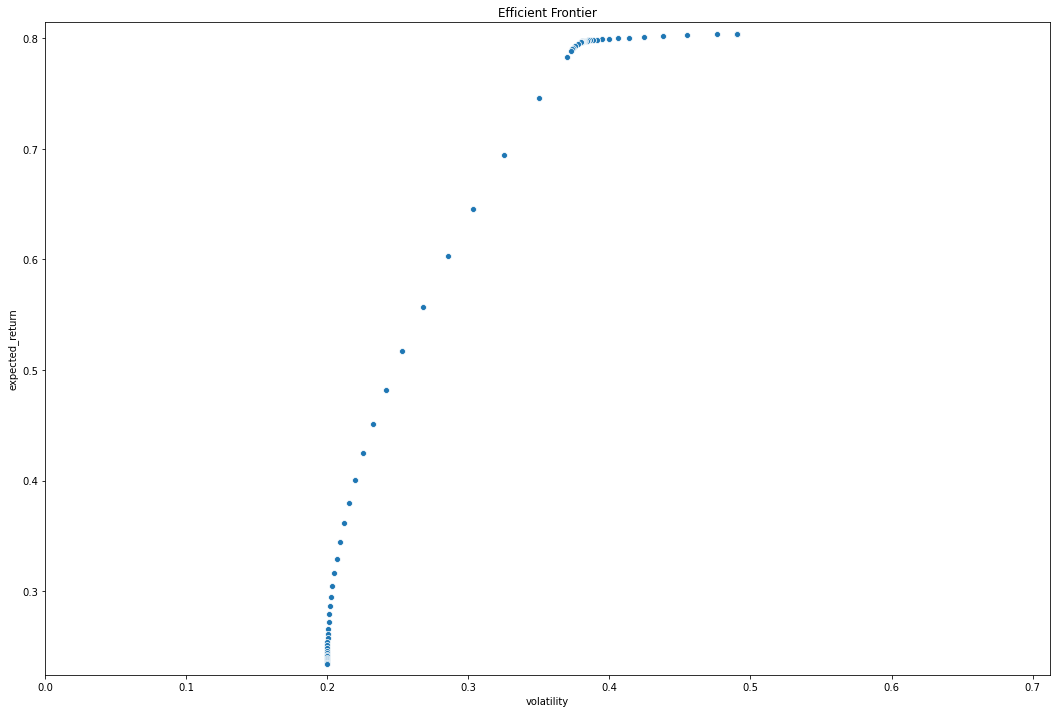

In [17]:
PortOpt.simulate_efficient_frontier(ret_format='sns', iters=100, leverage=2)

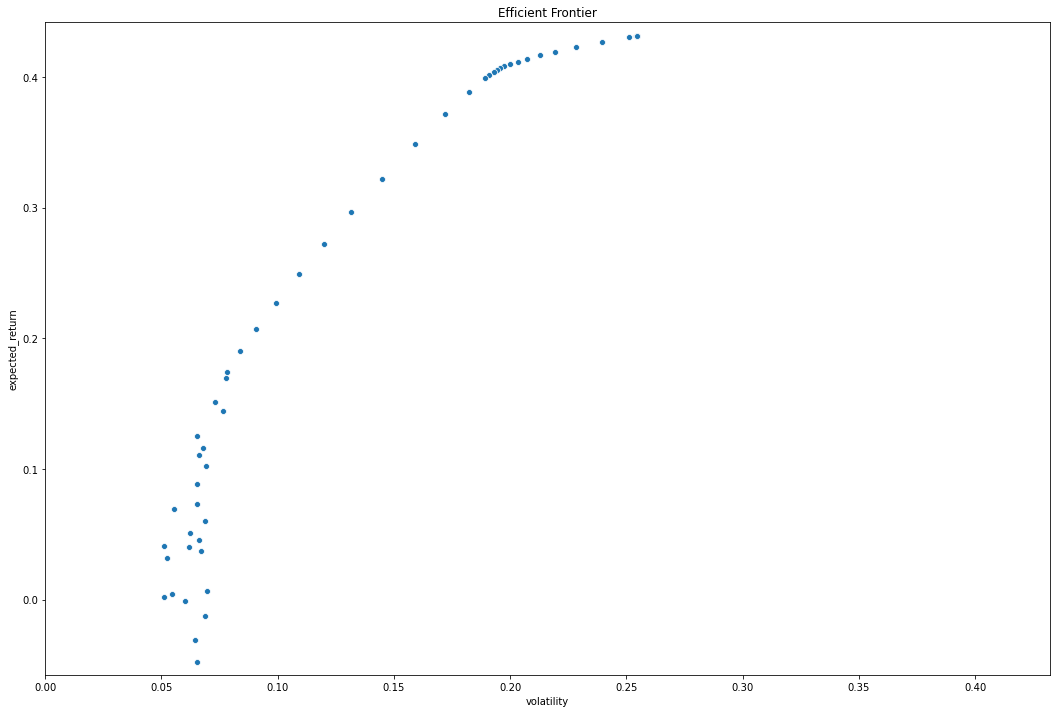

In [18]:
PortOpt.simulate_efficient_frontier(ret_format='sns', weight_bound=(-1, 1), leverage=1, iters=100)

In [19]:
PortOpt.simulate_efficient_frontier(ret_format='df', weight_bound=(-1, 1), leverage=1, iters=100).head()

volatility  expected_return  HUM  LHX    K  KSU  INTC  XOM  TGT  FISV  CVX  \
0    0.254414         0.431813  0.0  0.0  0.0  1.0   0.0  0.0  0.0   0.0  0.0   
1    0.254414         0.431813  0.0  0.0  0.0  1.0   0.0  0.0  0.0   0.0  0.0   
2    0.254414         0.431813  0.0  0.0  0.0  1.0   0.0  0.0  0.0   0.0  0.0   
3    0.254414         0.431813  0.0  0.0  0.0  1.0   0.0  0.0  0.0   0.0  0.0   
4    0.254414         0.431813  0.0  0.0  0.0  1.0   0.0  0.0  0.0   0.0  0.0   

   EXPD   HP  GPC  AIG  AON  GPS  
0   0.0  0.0  0.0  0.0  0.0  0.0  
1   0.0  0.0  0.0  0.0  0.0  0.0  
2   0.0  0.0  0.0  0.0  0.0  0.0  
3   0.0  0.0  0.0  0.0  0.0  0.0  
4   0.0  0.0  0.0  0.0  0.0  0.0

#### Example: Volatility VS Expected Return
- Set x = 'volatility', y = 'expected_return'
- Choose to return an sns plot, plotly plot or a dataframe
- Specify file_path when choosing to return an sns plot to save it in your directory
- Return a plotly figure for interaction
- Return a DataFrame with simulated weights for potentially more analysis

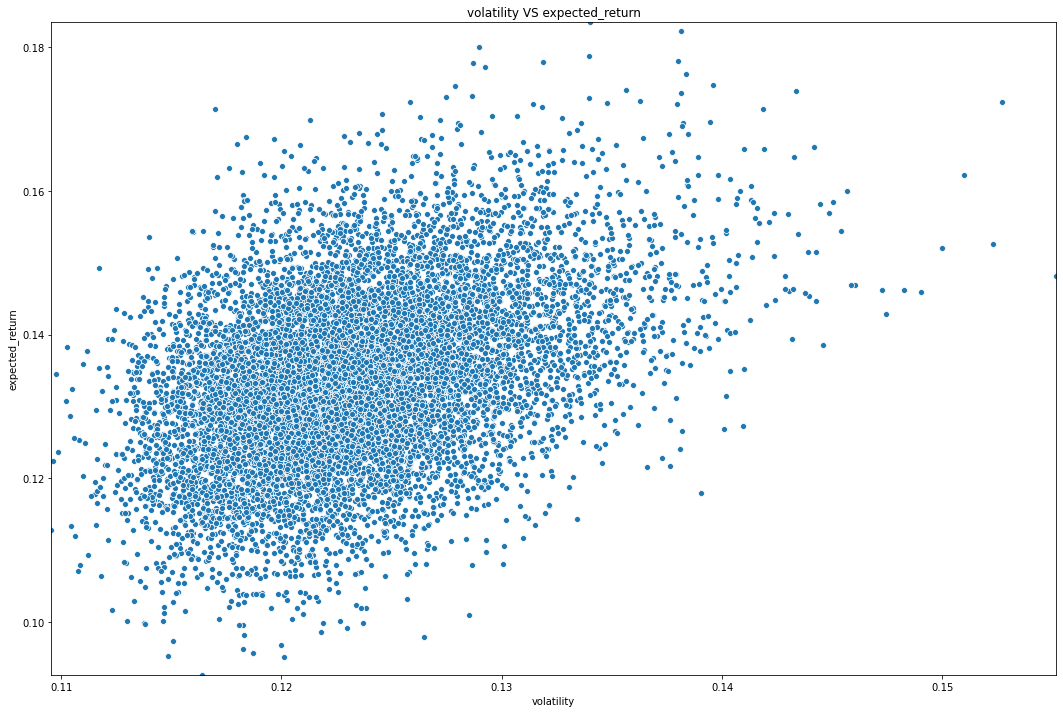

In [20]:
PortOpt.simulate(x='volatility', y='expected_return', iters=10000, weight_bound=(0, 1), leverage=1, ret_format='sns')

In [21]:
PortOpt.simulate(x='volatility', y='expected_return', iters=10000, weight_bound=(0, 1), leverage=1, ret_format='plotly')

In [22]:
sim_df = PortOpt.simulate(x='volatility', y='expected_return', iters=10000, weight_bound=(0, 1), leverage=1, ret_format='df')
sim_df.head()

volatility  expected_return       HUM       LHX         K       KSU  \
0    0.127278         0.143238  0.011680  0.006991  0.047992  0.021295   
1    0.127992         0.148450  0.000253  0.012847  0.010386  0.031809   
2    0.125332         0.127220  0.004611  0.010720  0.036485  0.025531   
3    0.118907         0.128554  0.006499  0.011518  0.018288  0.028572   
4    0.135207         0.148627  0.000148  0.004675  0.015427  0.041946   

       INTC       XOM       TGT      FISV       CVX      EXPD        HP  \
0  0.042658  0.050995  0.047811  0.072306  0.050402  0.083432  0.070112   
1  0.042173  0.041994  0.048958  0.123734  0.088672  0.110443  0.118542   
2  0.035016  0.054438  0.034094  0.056717  0.071730  0.157198  0.076055   
3  0.022318  0.054864  0.069361  0.100267  0.076006  0.059041  0.126114   
4  0.049759  0.037299  0.081399  0.044833  0.093288  0.040865  0.072783   

        GPC       AIG       AON       GPS  
0  0.097509  0.136662  0.105977  0.154178  
1  0.081082  0.062809  0.082259  0.144039  
2  0.090293  0.102487  0.118464  0.126161  
3  0.103517  0.112577  0.104322  0.106735  
4  0.102364  0.108188  0.118353  0.188672

#### Add Shortselling to see the symmetric Efficient Frontier

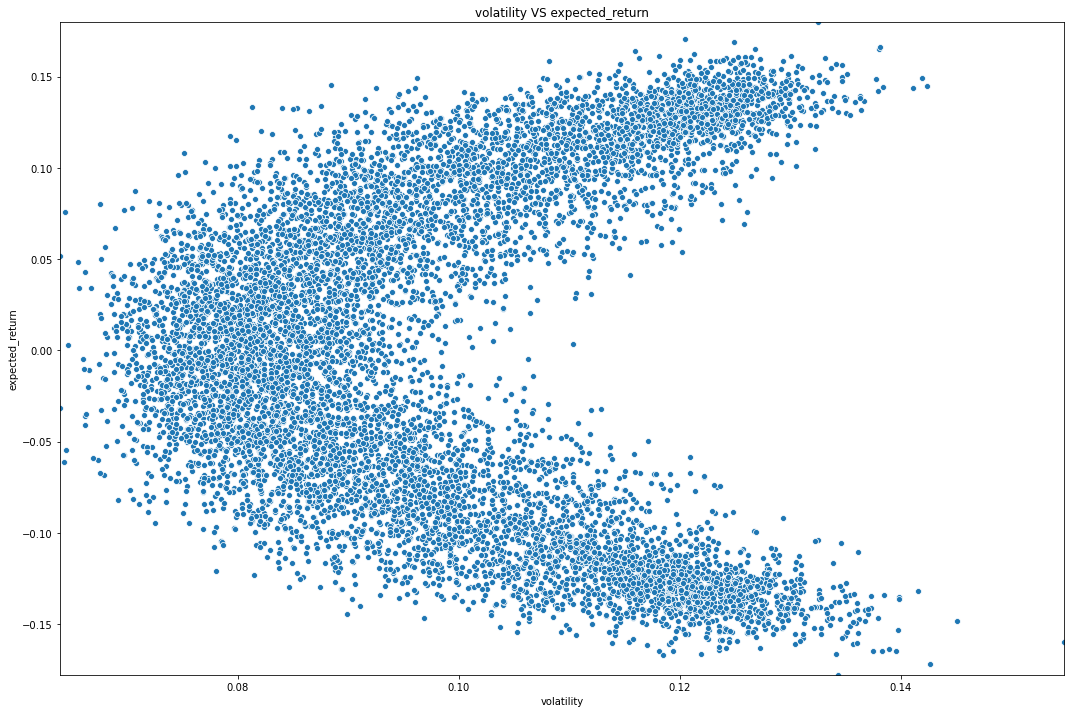

In [23]:
PortOpt.simulate(x='volatility', y='expected_return', iters=10000, weight_bound=(-0.25,0.25), leverage=1, ret_format='sns')

#### Example: Portfolio Beta & Expected Return
- The result should show a strong positive correlation

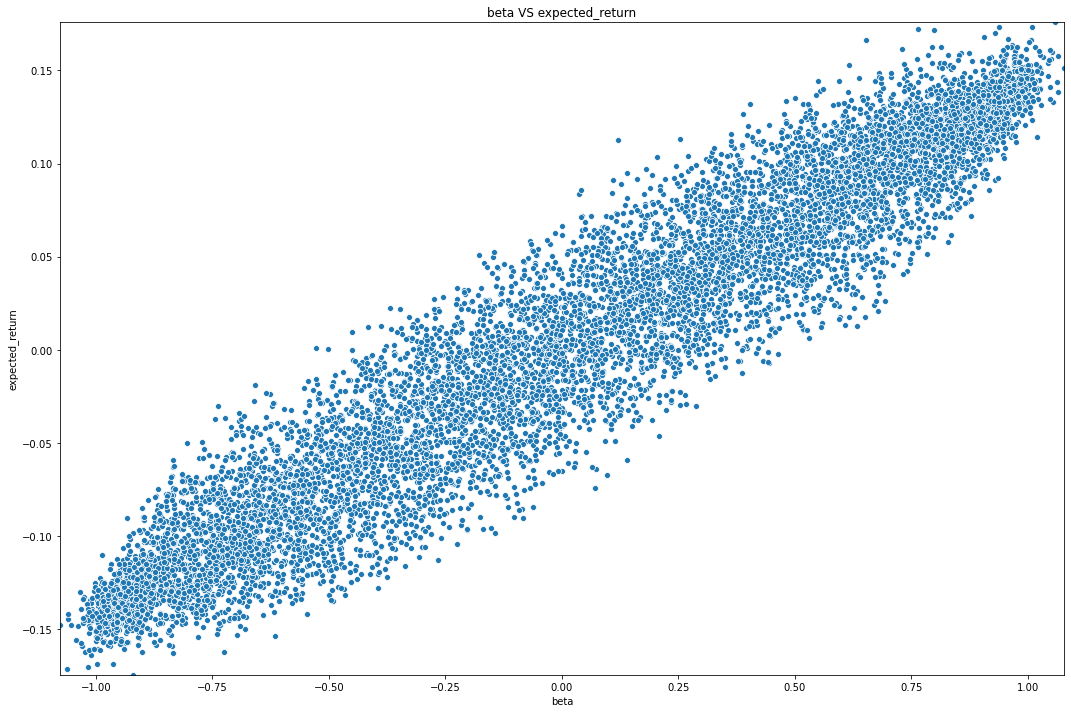

In [24]:
PortOpt.simulate(x='beta', y='expected_return', iters=10000, weight_bound=(-0.25,0.25), leverage=1, ret_format='sns')

#### Example: Portfolio Beta/Expected Return VS Sharpe Ratio
- Here, because sharpe ratio requires an additional metric, so must pass in a dictionary parameter y_var = {}

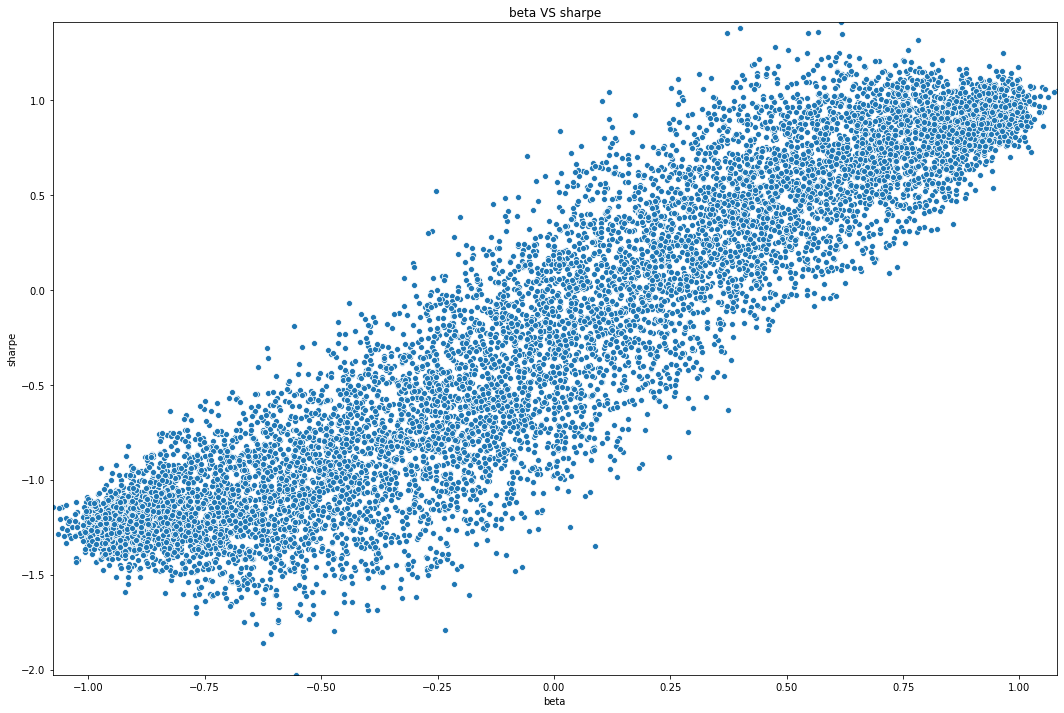

In [25]:
PortOpt.simulate(x='beta', y='sharpe', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

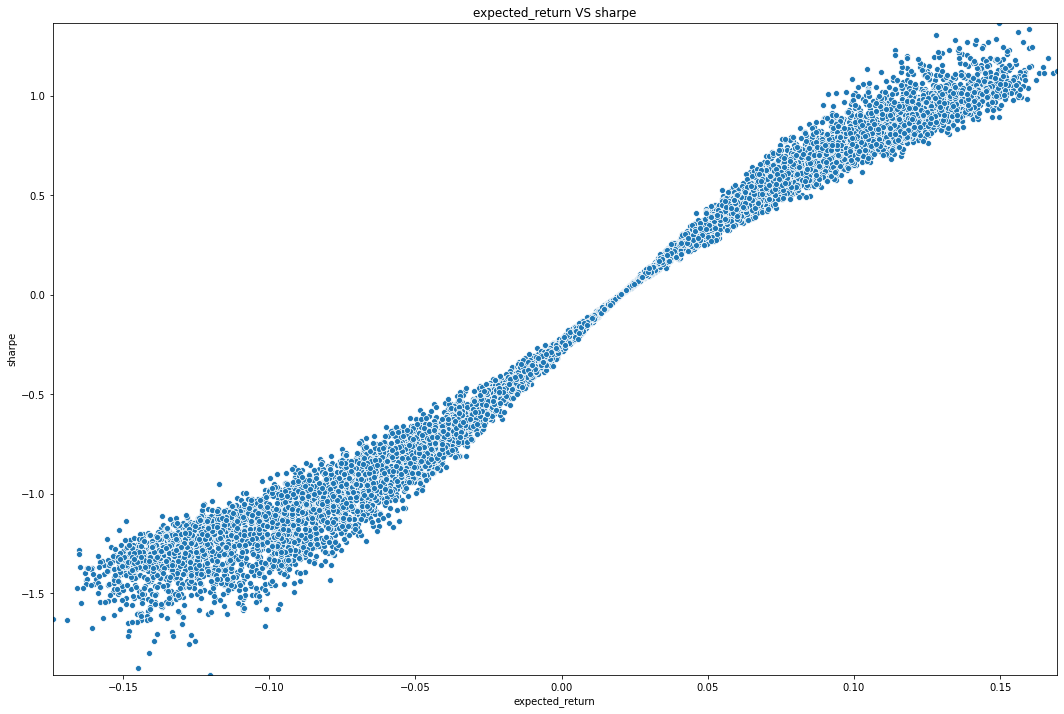

In [26]:
PortOpt.simulate(x='expected_return', y='sharpe', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns', file_path='return_vs_sharpe.png')

#### Example: Portfolio Beta/Expected Return VS Treynor Ratio/Jenson Alpha
- Treynor Ratio is calculated by dividing beta, so it has a lot of outliers, will use plotly to zoom in
- Jenson's Alpha calculates excess return

In [46]:
PortOpt.simulate(x='expected_return', y='treynor', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='plotly')

In [47]:
PortOpt.simulate(x='beta', y='treynor', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='plotly')

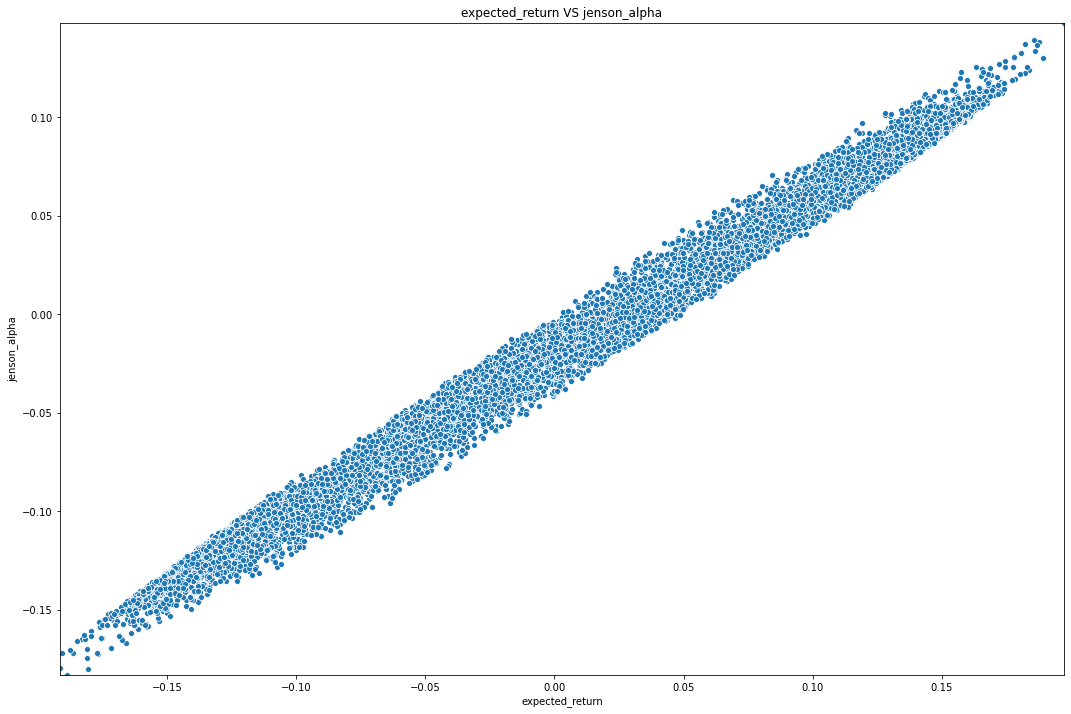

In [44]:
PortOpt.simulate(x='expected_return', y='jenson_alpha', y_var={"risk_free": 0.02, "market_return": 0.06}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

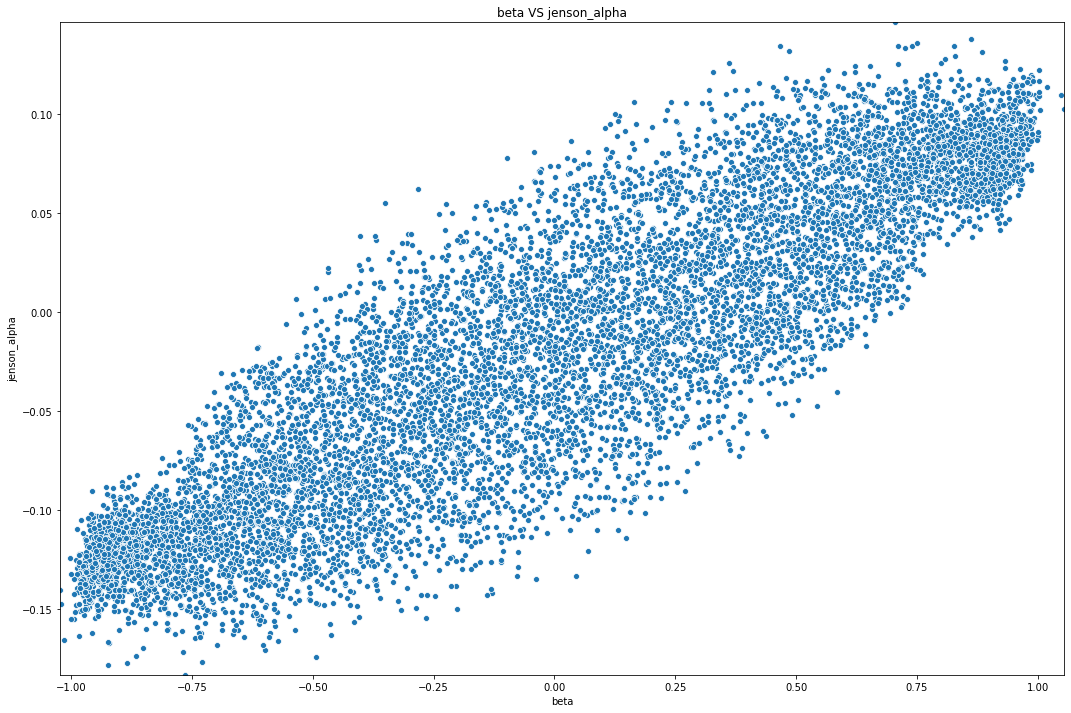

In [45]:
PortOpt.simulate(x='beta', y='jenson_alpha', y_var={"risk_free": 0.02, "market_return": 0.06}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

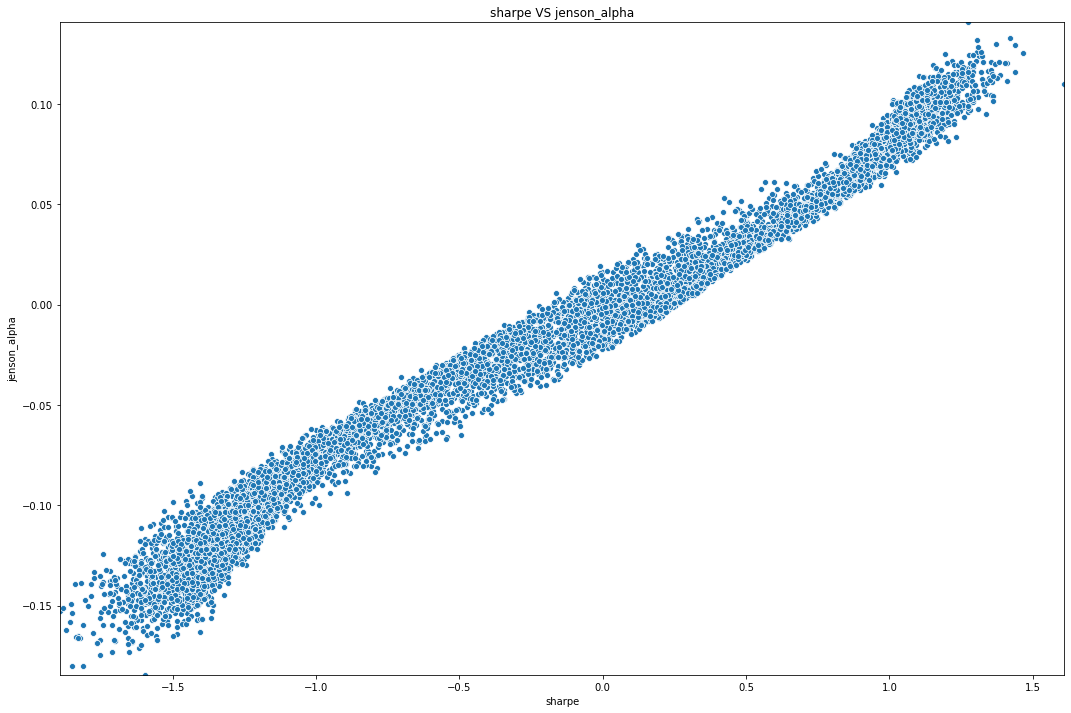

In [48]:
PortOpt.simulate(x='sharpe', y='jenson_alpha', x_var={"risk_free": 0.02}, y_var={"risk_free": 0.02, "market_return": 0.06}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

### Simulate Efficient Frontier for Skewness/Kurtosis
- More Negatively Skewed Portfolio has higher expected return/higher beta, though the relationship is not strictly linear
- 4th Central Moment (Kurtosis) Has an Efficient Frontier resembles 2nd Central Moment (Variance)

In [27]:
coskew_matrix = mom_generator.calc_coskew_mat()
PortOpt = Optimizer(mu_return, coskew_matrix, beta_vec)

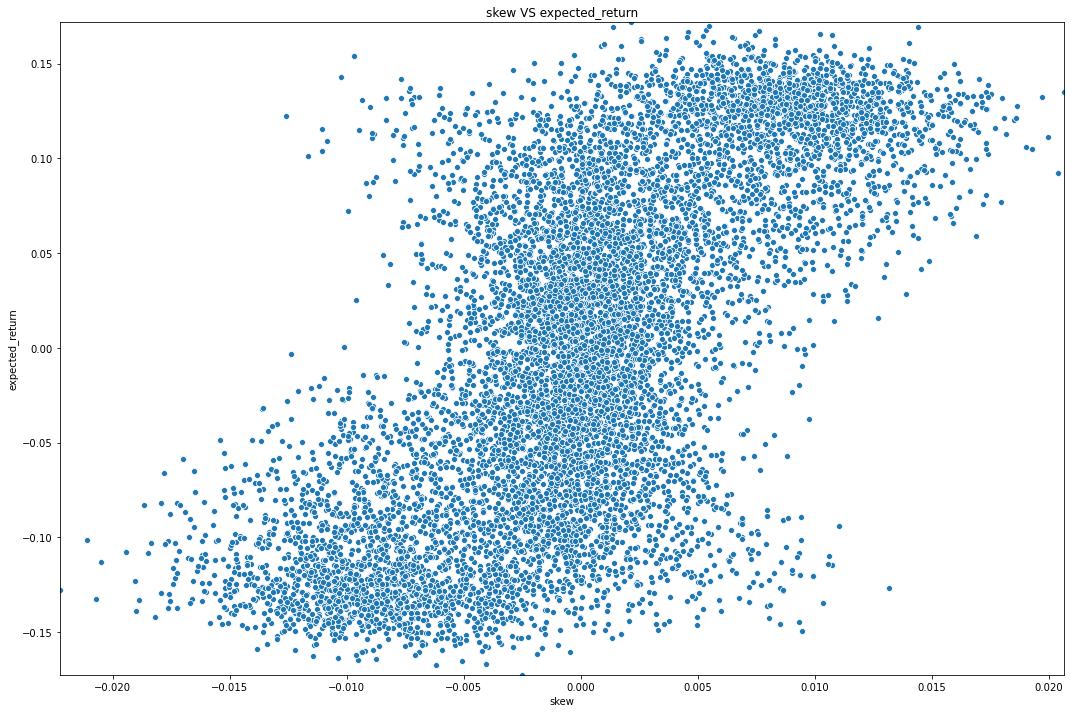

In [28]:
PortOpt.simulate(x='skew', y='expected_return', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns', file_path='skew_vs_return.png')

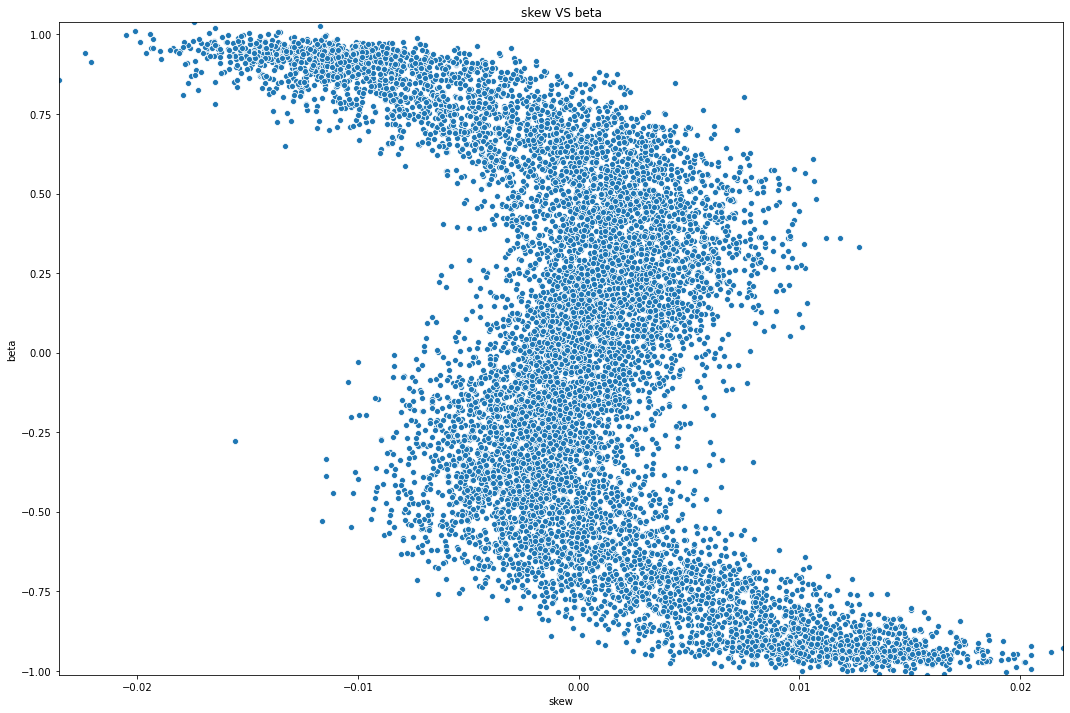

In [63]:
PortOpt.simulate(x='skew', y='beta', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

In [65]:
mom_generator = MomentGenerator(daily_return.iloc[:200])

In [66]:
cokurt_matrix = mom_generator.calc_cokurt_mat()
PortOpt = Optimizer(mu_return, cokurt_matrix, beta_vec)

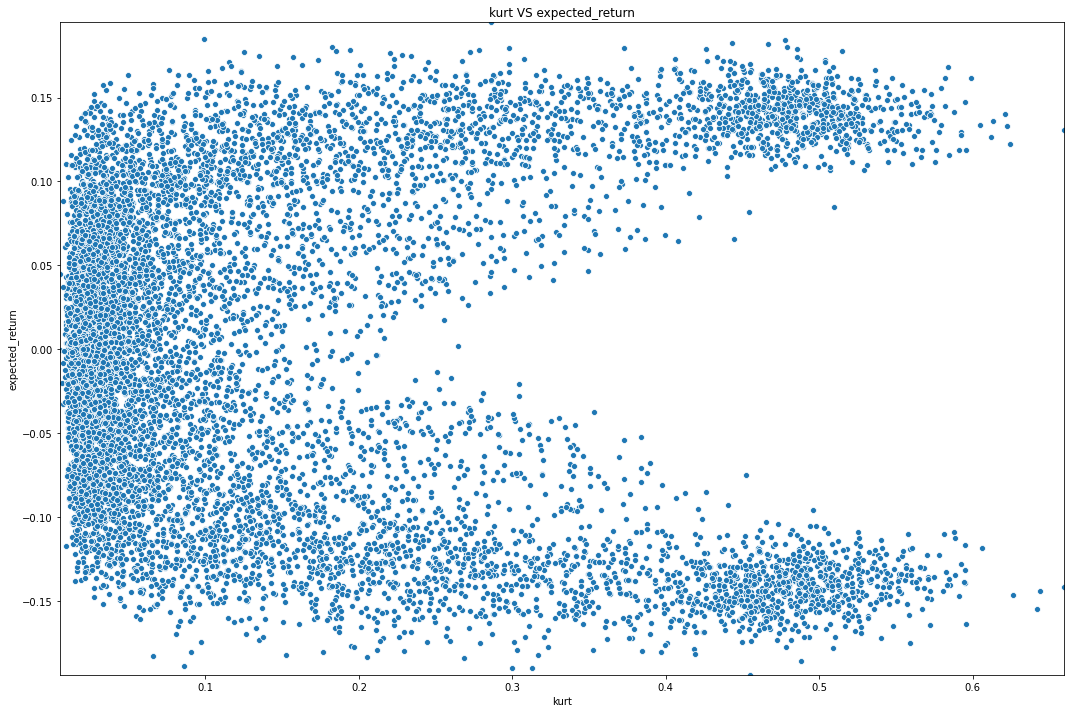

In [67]:
PortOpt.simulate(x='kurt', y='expected_return', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

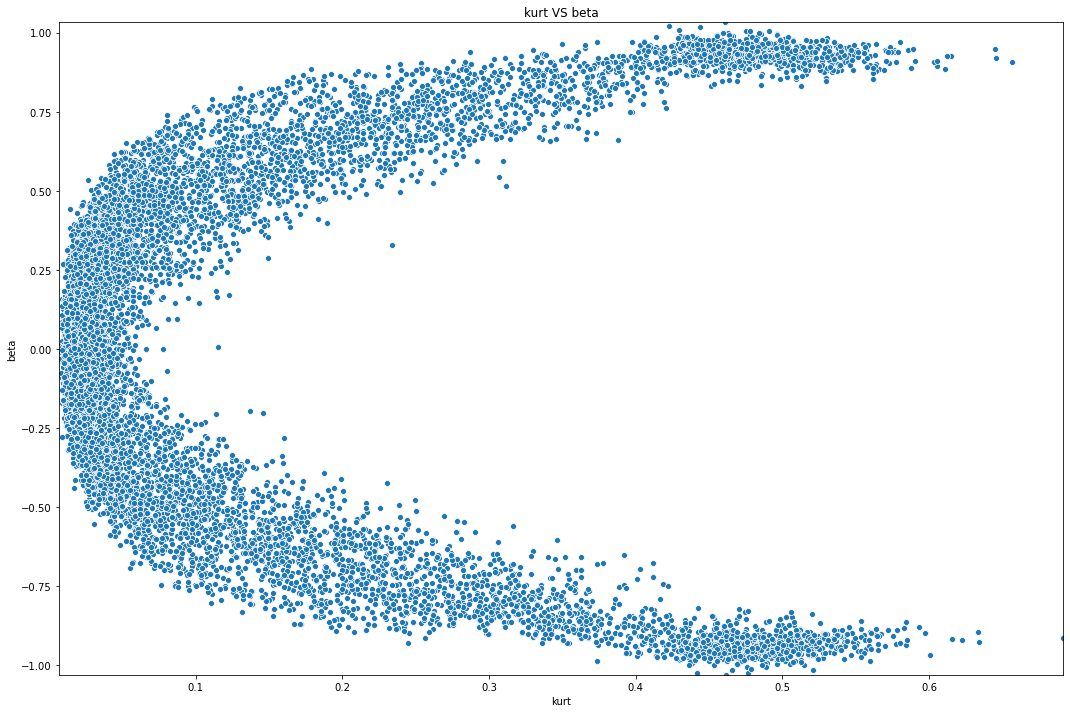

In [68]:
PortOpt.simulate(x='kurt', y='beta', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

### Higher Moment Simulation
- Example of 5th Moment Simulation

In [ ]:
mom_generator = MomentGenerator(daily_return.iloc[:100])
comoment_matrix = mom_generator.calc_comoment_mat(moment=5)
PortOpt = Optimizer(mu_return, comoment_matrix, beta_vec)

In [ ]:
PortOpt.simulate(x='moment', y='expected_return', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns', file_path='images/fifth_moment_vs_return.png')